## Segmentation d'images

<img src="mySaves/other_images/logo_future_vision_transport.png" alt="logo_future_vision_transport" width="400" class="center"/>

# Scrips

## I. Imports

In [17]:
# imports

import tensorflow as tf
import keras
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

import albumentations as A

import os

import numpy as np

import matplotlib.pyplot as plt

env: SM_FRAMEWORK=tf.keras


## II. Acceder aux données : Data Generator

In [2]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [3]:
class generator(keras.utils.Sequence) :
    '''
    data generator for cityscapes dataset :
        - gets every images (and masks) paths
        - reads images 
    '''

    def __init__(self, batch_size, images_path, masks_path, image_size, which_set, cats=None, augmentation=None, backbone=None, shuffle=False) :
        self.batch_size = batch_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_size = image_size
        self.which_set = which_set
        self.cats = cats
        self.augmentation = augmentation
        self.backbone = backbone
        self.shuffle = shuffle

        # initiate lists to store paths, 1 for images, 1 for masks
        self.images_path_list = []
        self.masks_path_list = []

        # for each folder and each list
        for path, l in zip(
            [self.images_path, self.masks_path],
            [self.images_path_list, self.masks_path_list]
        ) :
            # get set folder
            set_path = os.path.join(path,which_set)
            # put each city folder path in a list
            cities_list = os.listdir(set_path)
            cities_path_list = [os.path.join(set_path,city) for city in cities_list]
            # add images paths contained in each city folder
            # (carefull with mask, take PNG with "labelIds" in its name)
            l.extend([
                    os.path.join(city_path,img_file_name) \
                    for city_path in cities_path_list \
                        for img_file_name in os.listdir(city_path) \
                            if ("leftImg8bit" in img_file_name) or ("labelIds" in img_file_name)
            ])
            # sort
            l.sort()

        # indexes in an attribute
        self.indexes = np.arange(len(self.images_path_list))
        # apply "on_epoch_end" for shuffling (see below)
        self.on_epoch_end()

    def __len__(self) :
        """Denotes the number of batches per epoch"""
        # return int(np.floor(len(self.images_path_list)/self.batch_size))
        return len(self.images_path_list) // self.batch_size
    
    def __getitem__(self, batch_idx) :
        # indexes for this batch
        start = batch_idx * self.batch_size
        stop = (batch_idx +1) * self.batch_size
        indexes_for_this_batch = self.indexes[start:stop]
        # initiate lists for this batch
        batch_images = []
        batch_masks = []
        # build batch
        for i in indexes_for_this_batch :
            # load image and mask as arrays 
            image = keras.preprocessing.image.load_img(self.images_path_list[i], target_size=self.image_size)
            image = keras.preprocessing.image.img_to_array(image, dtype="uint8")
            mask = keras.preprocessing.image.load_img(self.masks_path_list[i], color_mode = "grayscale", target_size=self.image_size)
            mask = keras.preprocessing.image.img_to_array(mask)

            # apply augmentation
            if self.augmentation :
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample["image"], sample["mask"]

            # apply preprocessing, for backbone compatibility
            if self.backbone :
                preprocessor = sm.get_preprocessing(self.backbone)
                preprocessor = A.Lambda(image=preprocessor)
                preprocessor = A.Compose([preprocessor])
                sample = preprocessor(image=image, mask=mask)
                image, mask = sample["image"], sample["mask"]

            # simplify categories
            if self.cats :
                for k, list_of_labels in enumerate(self.cats.values()) :
                    mask = np.where(np.isin(mask,list_of_labels),k,mask).astype("uint8")

            # cast mask to categorical
            mask = keras.utils.to_categorical(mask, num_classes=len(self.cats), dtype="uint8")

            # add to lists
            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes at each epoch"""
        if self.shuffle :
            self.indexes = np.random.permutation(self.indexes)

        


In [4]:
# define augmentations for training
list_of_transforms = [
    A.HorizontalFlip(p=0.5), 
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=25,
        p=0.5
    ),
    A.RandomCrop(
            height=192,
            width=192*2,
            p=0.5
        ),
    A.PadIfNeeded(
        min_height=256,
        min_width=512,
        p=1
        ),
    A.OneOf(
        [
            A.CLAHE(p=1, clip_limit=6),
            A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=0.5
    ),
    A.OneOf(
        [
            A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            A.Blur(p=1, blur_limit=9),
            A.MotionBlur(p=1, blur_limit=9)
        ],
        p=0.5
    ),
    A.HueSaturationValue(
        p=0.5, 
        hue_shift_limit=120, 
        sat_shift_limit=2, 
        val_shift_limit=100
        )
]

    


In [5]:
gen = generator(
    batch_size=32,
    images_path='P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/', 
    masks_path='P8_Cityscapes_gtFine_trainvaltest/gtFine/',
    image_size=(256, 256*2),
    which_set="val",
    cats=cats,
    backbone = "resnet34",
    
)

In [6]:
genAug = generator(
    batch_size=32,
    images_path='P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/', 
    masks_path='P8_Cityscapes_gtFine_trainvaltest/gtFine/',
    image_size=(256, 256*2),
    which_set="val",
    cats=cats,
    backbone = "resnet34",
    augmentation=A.Compose(list_of_transforms)
    
)

# Tests aumgentations

In [78]:
def testAlbu(trans, idx) :
    image = gen[0][0][idx]
    mask = gen[0][1][idx]

    aug = A.Compose(trans)
    sample = aug(image=image, mask=mask)

    fig, axs = plt.subplots(2,2,figsize=(14,7))
    axs = axs.flatten()

    image_aug = sample["image"]
    mask = np.expand_dims(np.argmax(mask, axis=2), axis=2)
    mask_aug = np.expand_dims(np.argmax(sample["mask"], axis=2), axis=2)

    for i,im in enumerate([image, mask, image_aug, mask_aug]) :
        axs[i].imshow(im)
        axs[i].set_axis_off()
    # display(keras.preprocessing.image.array_to_img(image))
    # aug = A.Compose(trans)
    # aug_image = aug(image=image)["image"]
    # print(aug_image.shape)
    # return keras.preprocessing.image.array_to_img(aug_image)

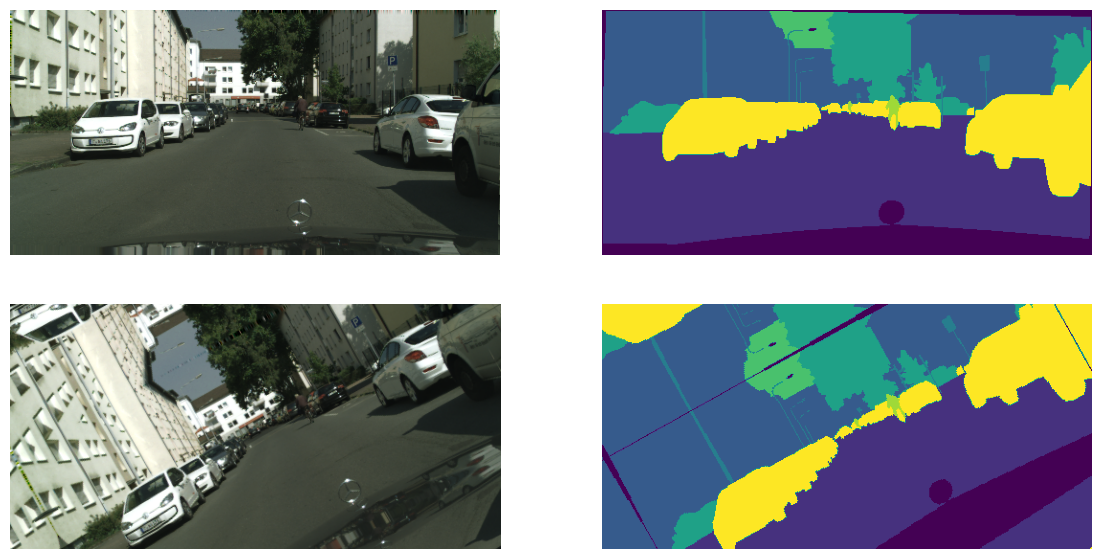

In [51]:
testAlbu(
    [A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=30,
        p=1,
    )]
)

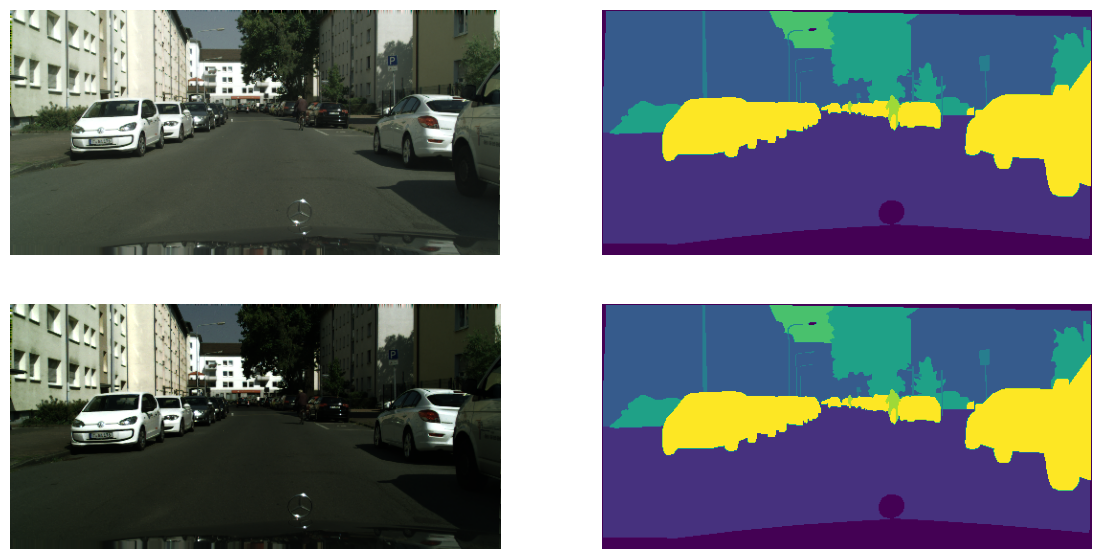

In [52]:
testAlbu(
    [A.OneOf(
        [
            # A.CLAHE(p=1, clip_limit=6),
            # A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=1
    )]
)

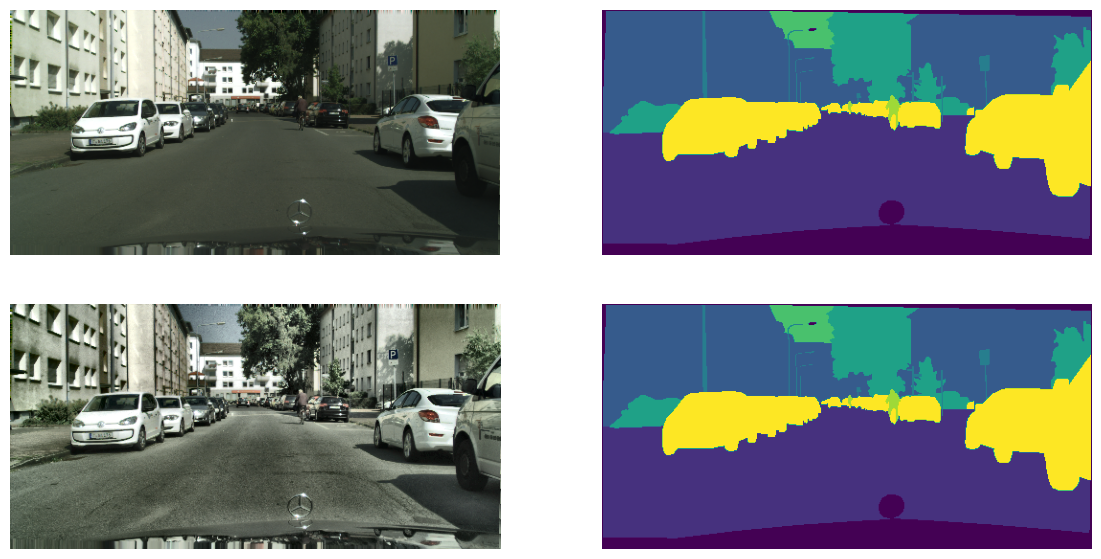

In [53]:
testAlbu(
    [A.OneOf(
        [
            A.CLAHE(p=1, clip_limit=6),
            # A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            # A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=1
    )]
)

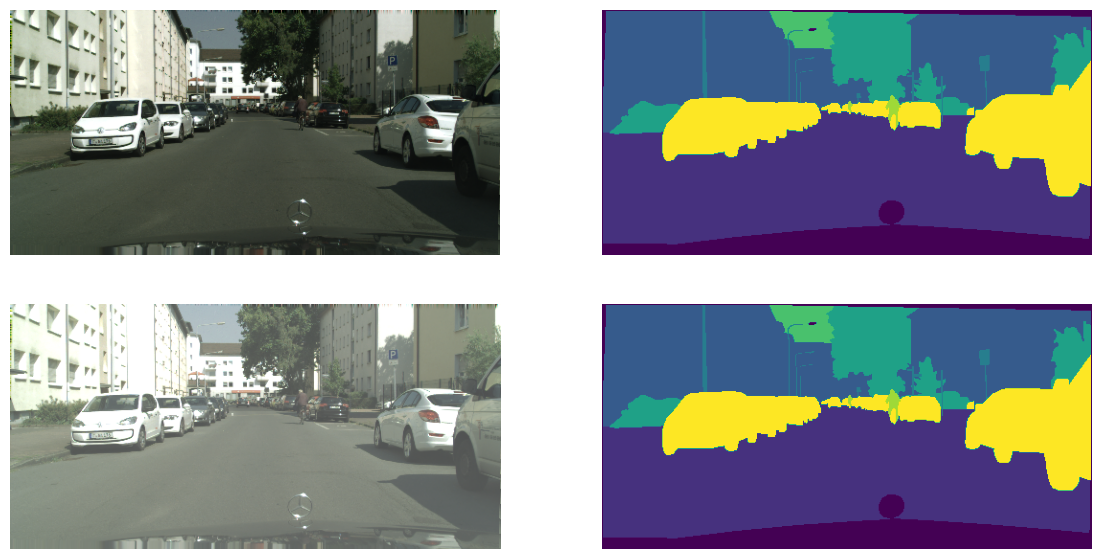

In [54]:
testAlbu(
    [A.OneOf(
        [
            # A.CLAHE(p=1, clip_limit=6),
            A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            # A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=1
    )]
)

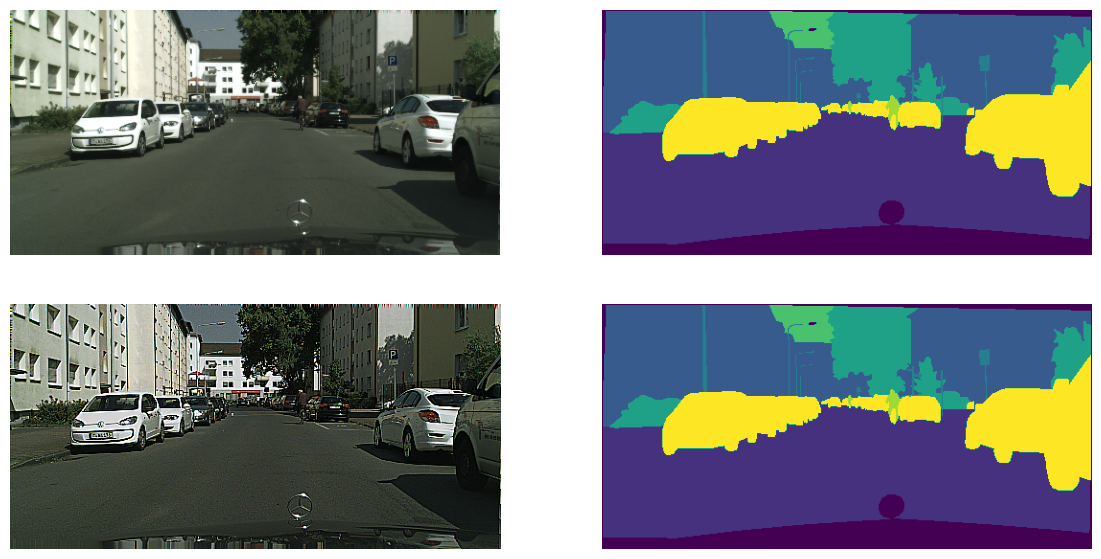

In [55]:
testAlbu(
    [A.OneOf(
        [
            A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            # A.Blur(p=1, blur_limit=9),
            # A.MotionBlur(p=1, blur_limit=9)
        ],
        p=1
    )]
)

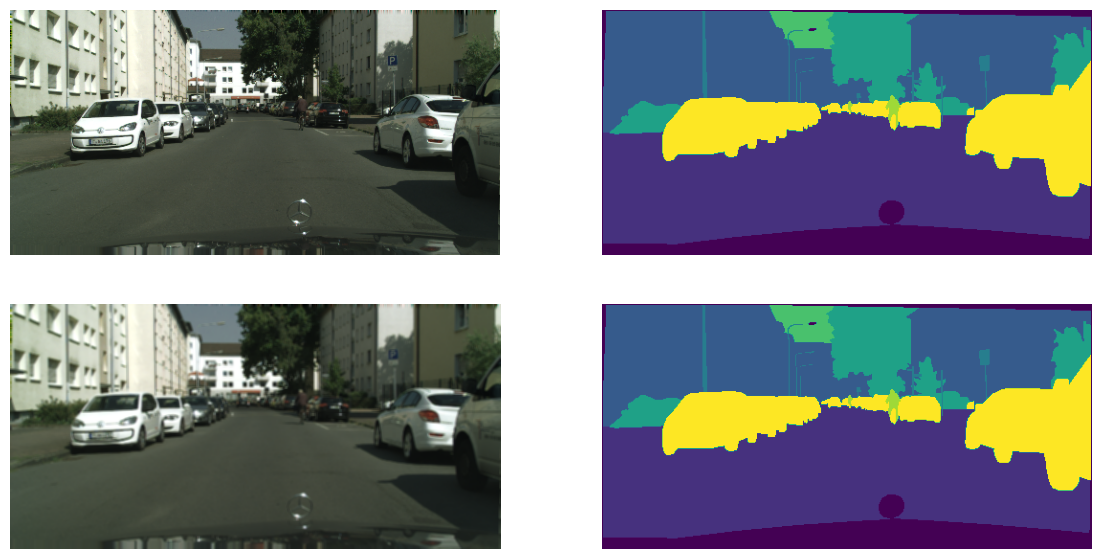

In [56]:
testAlbu(
    [A.OneOf(
        [
            # A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            A.Blur(p=1, blur_limit=9),
            # A.MotionBlur(p=1, blur_limit=9)
        ],
        p=1
    )]
)

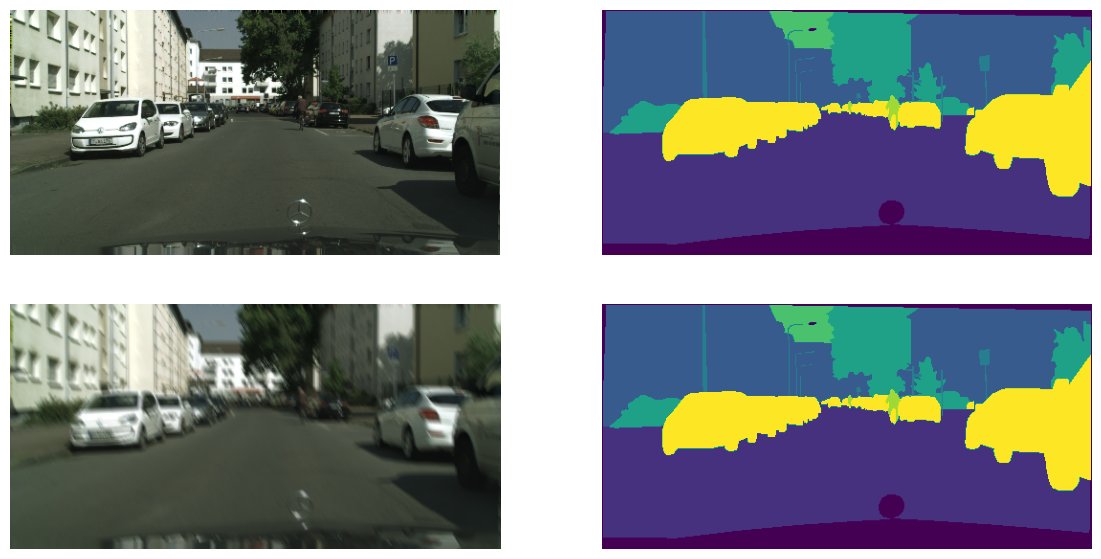

In [57]:
testAlbu(
    [A.OneOf(
        [
            # A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            # A.Blur(p=1, blur_limit=9),
            A.MotionBlur(p=1, blur_limit=9)
        ],
        p=1
    )]
)

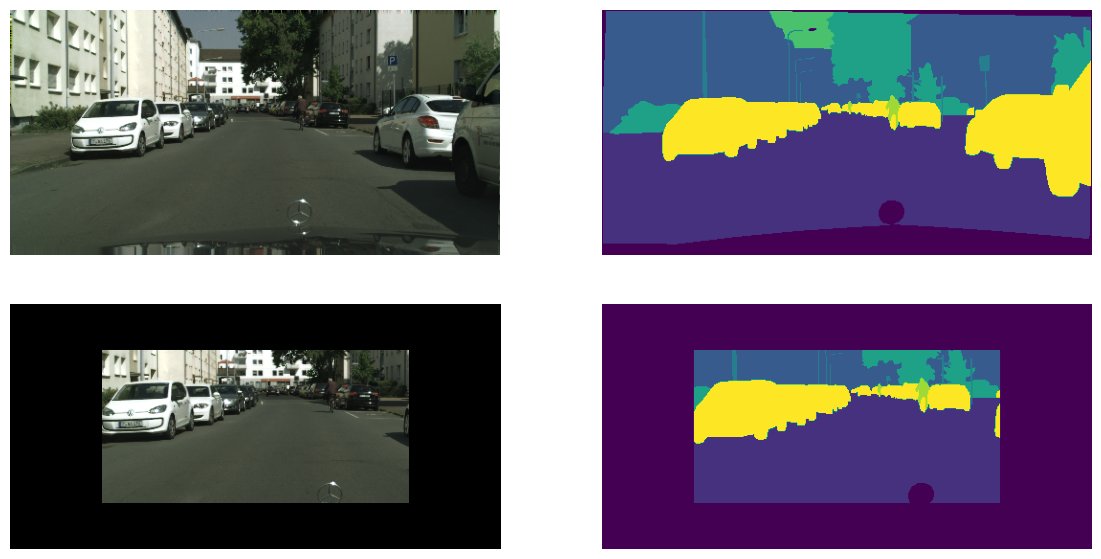

In [76]:
testAlbu(
    [A.RandomCrop(
        height=160,
        width=160*2,
        p=1
    ),
    A.PadIfNeeded(
        min_height=256,
        min_width=512,
        border_mode = 0,
        p=1
    )]
)

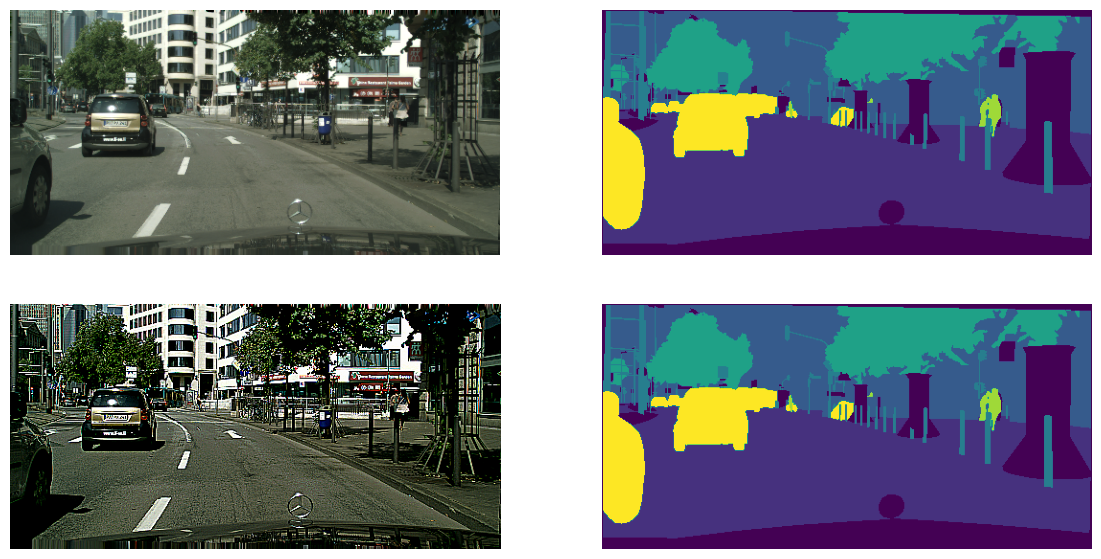

In [79]:
testAlbu(list_of_transforms, idx = 30)